# Incertidumbre de la predicción

In [2]:
import sys
# Spark utils
from pyspark.sql.functions import (udf, col, decode, when, lit, lower, concat,
                                   translate, count, sum as sql_sum, max as sql_max, min as sql_min, avg as sql_avg,
                                   greatest,
                                   least,
                                   isnull,
                                   isnan,
                                   struct, 
                                   substring,
                                   size,
                                   length,
                                   year,
                                   month,
                                   dayofmonth,
                                   unix_timestamp,
                                   date_format,
                                   from_unixtime, 
                                   datediff,
                                   to_date, 
                                   desc,
                                   asc,
                                   countDistinct,
                                   row_number,
                                   regexp_replace,
                                   first,
                                   to_timestamp,
                                   lpad,
                                   rpad,
                                   coalesce, udf, date_add, explode, collect_set, length, expr, split)
from pyspark.sql import Row, DataFrame, Column, Window
from pyspark.sql.types import DoubleType, StringType, IntegerType, DateType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, SQLTransformer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from datetime import datetime
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Lectura de predicciones finales

In [3]:
def set_paths():

    import os
    import sys

    USECASES_SRC = os.path.join(os.environ.get('BDA_USER_HOME', ''), "repositorios", "use-cases")
    if USECASES_SRC not in sys.path:
        sys.path.append(USECASES_SRC)


set_paths()

In [4]:
from churn_nrt.src.utils.spark_session import get_spark_session

sc, spark, sql_context=get_spark_session(app_name="certidumbre_multilabel_eval")

In [5]:
pred=spark.read.load('/data/udf/vf_es/churn/churn_competitor_model/v2/multiclase/multilabel_predictions_no_navcomp_new')

AnalysisException: u'Path does not exist: hdfs://nameservice1/data/udf/vf_es/churn/churn_competitor_model/v2/multiclase/pred_20200131_evaluation;'

In [5]:
pred=pred.drop('prediction_multilabel','label_multilabel','acierto_multilabel')

In [6]:
pred.limit(5).toPandas()

,msisdn,prob_array,prediction,label
0,687596820,"[0.208676573109, 0.35431270528, 0.252325356083...",2.0,2
1,684899632,"[0.275269833392, 0.153740854169, 0.26992324297...",4.0,4
2,713561157,"[0.260734257256, 0.245426040607, 0.24962601438...",1.0,1
3,651941058,"[0.232677887307, 0.27105560407, 0.218171891859...",4.0,4
4,689991908,"[0.266633757298, 0.240384723713, 0.25438988295...",1.0,1


## Incertidumbre tipo I: 1ª Prob Max - 2ª Prob Max 

Sort array of probabilities (prob_array) and get the difference between the first and second higher score. The column resulting from that calculation will be the uncertainity of type 1 (uncertainity_1)

In [7]:
from pyspark.sql.functions import sort_array,col

pred2 = pred.withColumn('prob_sorted', sort_array(pred['prob_array'])).cache()

# Get column with first and second position of the array ordered (max1, max2)

pred2 = pred2.withColumn("uncertainity_1", 
                         (pred2["prob_sorted"].getItem(3)-pred2["prob_sorted"].getItem(2))).cache()

In [8]:
pred2.limit(5).toPandas()

,msisdn,prob_array,prediction,label,prob_sorted,uncertainity_1
0,687596820,"[0.208676573109, 0.35431270528, 0.252325356083...",2.0,2,"[0.184685365528, 0.208676573109, 0.25232535608...",0.101987
1,684899632,"[0.275269833392, 0.153740854169, 0.26992324297...",4.0,4,"[0.153740854169, 0.269923242977, 0.27526983339...",0.025796
2,713561157,"[0.260734257256, 0.245426040607, 0.24962601438...",1.0,1,"[0.244213687752, 0.245426040607, 0.24962601438...",0.011108
3,651941058,"[0.232677887307, 0.27105560407, 0.218171891859...",4.0,4,"[0.218171891859, 0.232677887307, 0.27105560407...",0.007039
4,689991908,"[0.266633757298, 0.240384723713, 0.25438988295...",1.0,1,"[0.238591636036, 0.240384723713, 0.25438988295...",0.012244


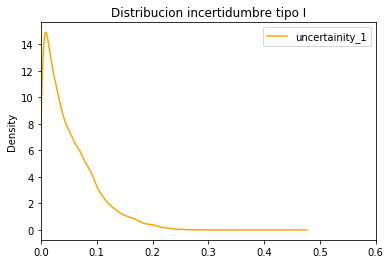

In [9]:
pred2.select("uncertainity_1")\
.toPandas()\
.plot.kde(xlim=[0, 0.6], title='Distribucion incertidumbre tipo I',color='orange')

In [10]:
pred2.orderBy('uncertainity_1',ascending=False).limit(5).toPandas()

,msisdn,prob_array,prediction,label,prob_sorted,uncertainity_1
0,600126391,"[0.193326977268, 0.151993312745, 0.14379513559...",4.0,4,"[0.143795135598, 0.151993312745, 0.19332697726...",0.317558
1,609436292,"[0.166152819459, 0.490978049251, 0.17819021084...",2.0,2,"[0.164678920443, 0.166152819459, 0.17819021084...",0.312788
2,625491061,"[0.480843213049, 0.147803446471, 0.18623302793...",1.0,1,"[0.147803446471, 0.185120312547, 0.18623302793...",0.294610
3,611500088,"[0.168217318628, 0.479243690128, 0.19035889360...",2.0,2,"[0.162180097639, 0.168217318628, 0.19035889360...",0.288885
4,695829103,"[0.193717276184, 0.163516966833, 0.16671445330...",4.0,4,"[0.163516966833, 0.166714453306, 0.19371727618...",0.282334


In [11]:
pred2_pd=pred2.toPandas()
from sklearn.metrics import f1_score, accuracy_score

threshold = np.linspace(0, 0.317558, 100).tolist()

columns = ['threshold', 'F1_score','Count','Accuracy']
vals = [(0, 0, 0,0)]

df = spark.createDataFrame(vals, columns)

for i in range(0,(len(threshold)-1)):

    
    count=pred2_pd[pred2_pd['uncertainity_1']>=threshold[i]].shape[0]
    accuracy=accuracy_score(pred2_pd[pred2_pd['uncertainity_1']>=threshold[i]]['label'], pred2_pd[pred2_pd['uncertainity_1']>=threshold[i]]['prediction'])
    f1=f1_score(pred2_pd[pred2_pd['uncertainity_1']>=threshold[i]]['label'], pred2_pd[pred2_pd['uncertainity_1']>=threshold[i]]['prediction'], average='weighted')
    newRow = spark.createDataFrame([(threshold[i],f1.item(),count,accuracy.item())], columns)
    df = df.union(newRow)
    

/opt/cloudera/parcels/Anaconda-2.5.0/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
f1_incertidumbre_1 = df.filter((df.Count != 0.0))

In [13]:
f1_incertidumbre_1 =f1_incertidumbre_1.withColumn('perc_churners',col('Count').cast(IntegerType())/97785)

In [14]:
f1_incertidumbre_1.filter(col('F1_score')>=0.58).orderBy('F1_score').limit(5).toPandas()

,threshold,F1_score,Count,Accuracy,perc_churners
0,0.083399,0.581487,20415,0.591477,0.208774
1,0.086607,0.589569,18936,0.599176,0.193649
2,0.089814,0.600223,17541,0.609543,0.179383
3,0.093022,0.608429,16172,0.617549,0.165383
4,0.096230,0.616594,14975,0.625710,0.153142


In [15]:
f1_incertidumbre_1.toPandas().to_csv('performance_vs_certidumbre1.csv')

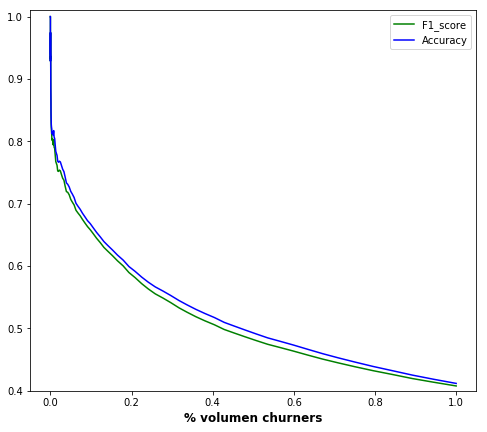

In [16]:
fig,ax = plt.subplots(figsize=(8,7))
font={'fontsize':12, 'fontweight': 'bold'}

ax.plot(f1_incertidumbre_1.toPandas().perc_churners, f1_incertidumbre_1.toPandas().F1_score,color='green')
ax.plot(f1_incertidumbre_1.toPandas().perc_churners, f1_incertidumbre_1.toPandas().Accuracy,color='blue')

ax.set_ylim([0.4,1.01])

ax.set_xlabel("% volumen churners", fontdict = font)
ax.legend(loc='best')

## Incertidumbre tipo II: Entriopía de los scores

NameError: name 'spark' is not defined

In [17]:
pred2=pred #aquí se la hemos aplicado al multilabel

In [18]:
from  pyspark.sql.functions import log

pred3 = pred2.withColumn("uncertainity_2", -(pred2["prob_array"].getItem(0)*log(pred2["prob_array"].getItem(0))
                                          +pred2["prob_array"].getItem(1)*log(pred2["prob_array"].getItem(1))
                                          +pred2["prob_array"].getItem(2)*log(pred2["prob_array"].getItem(2))
                                          +pred2["prob_array"].getItem(3)*log(pred2["prob_array"].getItem(3)))
                        )

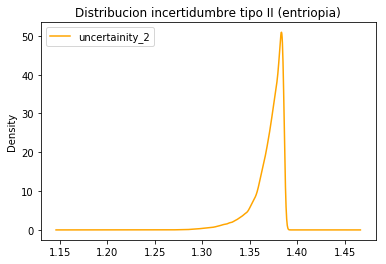

In [19]:
pred3.select("uncertainity_2")\
.toPandas()\
.plot.kde(title='Distribucion incertidumbre tipo II (entriopia)',color='orange')

In [23]:
pred3_pd=pred3.toPandas()



In [25]:
pred3_pd

,msisdn,prob_array,prediction,label,uncertainity_2
0,687596820,"[0.208676573109, 0.35431270528, 0.252325356083...",2.0,2,1.354029
1,684899632,"[0.275269833392, 0.153740854169, 0.26992324297...",4.0,4,1.357880
2,713561157,"[0.260734257256, 0.245426040607, 0.24962601438...",1.0,1,1.385957
3,651941058,"[0.232677887307, 0.27105560407, 0.218171891859...",4.0,4,1.381177
4,689991908,"[0.266633757298, 0.240384723713, 0.25438988295...",1.0,1,1.385263
5,680224641,"[0.213513762019, 0.338500961092, 0.26949844779...",2.0,3,1.357291
6,672663721,"[0.247571236076, 0.241713460455, 0.23539470790...",4.0,1,1.384467
7,643477293,"[0.218683997057, 0.28628265412, 0.228529748958...",2.0,2,1.380249
8,665891782,"[0.30597332091, 0.193167514075, 0.208952873829...",1.0,3,1.366534
9,635597055,"[0.231324177871, 0.164245203203, 0.23608797648...",4.0,4,1.344019


In [24]:
pred3_pd=pred3.toPandas()
from sklearn.metrics import f1_score, accuracy_score

threshold = np.linspace(1.226039, 1.386289, 100).tolist()

columns = ['threshold','Count','Accuracy']
vals = [(0, 0, 0)]

df = spark.createDataFrame(vals, columns)

for i in range(0,(len(threshold)-1)):

    pred=pred3_pd[pred3_pd['uncertainity_2']<=threshold[i]]
    count=pred.shape[0]
    accuracy=float(pred[pred['acierto_multilabel']==1].shape[0])/float(count)
    newRow = spark.createDataFrame([(threshold[i],count,accuracy)], columns)
    df = df.union(newRow)
    

KeyError: 'acierto_multilabel'

In [ ]:
f1_incertidumbre_2 = df.filter((df.threshold != 0.0))

In [ ]:
f1_incertidumbre_2 =f1_incertidumbre_2.withColumn('perc_churners',col('Count').cast(IntegerType())/97785)

In [ ]:
f1_incertidumbre_2.toPandas()

In [25]:
f1_incertidumbre_2.toPandas().to_csv('performance_multilab_vs_certidumbre2.csv')

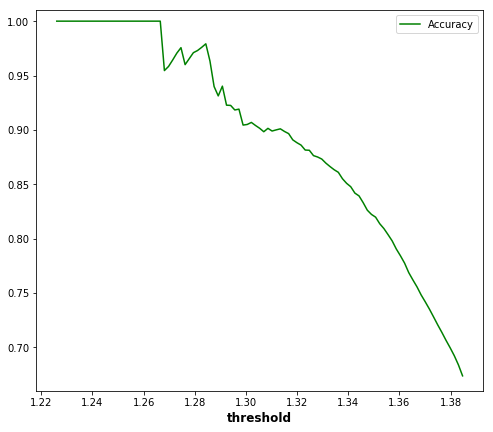

In [30]:
fig,ax = plt.subplots(figsize=(8,7))
font={'fontsize':12, 'fontweight': 'bold'}

ax.plot(f1_incertidumbre_2.toPandas().threshold, f1_incertidumbre_2.toPandas().Accuracy,color='green')
ax.set_ylim([0.66,1.01])

ax.set_xlabel("threshold", fontdict = font)
ax.legend(loc='best')

In [5]:
import pandas as pd

f1_incertidumbre_2=pd.read_csv('performance_multilab_vs_certidumbre2.csv')


In [6]:
f1_incertidumbre_2

,Unnamed: 0,threshold,Count,Accuracy,perc_churners
0,0,1.226039,1,1.000000,0.000010
1,1,1.227658,1,1.000000,0.000010
2,2,1.229276,1,1.000000,0.000010
3,3,1.230895,1,1.000000,0.000010
4,4,1.232514,1,1.000000,0.000010
5,5,1.234132,1,1.000000,0.000010
6,6,1.235751,1,1.000000,0.000010
7,7,1.237370,1,1.000000,0.000010
8,8,1.238988,2,1.000000,0.000020
9,9,1.240607,2,1.000000,0.000020


In [4]:
f1_incertidumbre_2[f1_incertidumbre_2['threshold']<=1.39]

,Unnamed: 0,threshold,F1_score,Count,Accuracy,perc_churners
0,0,1.226039,1.000000,1,1.000000,0.000010
1,1,1.227658,1.000000,1,1.000000,0.000010
2,2,1.229276,1.000000,1,1.000000,0.000010
3,3,1.230895,1.000000,1,1.000000,0.000010
4,4,1.232514,1.000000,1,1.000000,0.000010
5,5,1.234132,1.000000,1,1.000000,0.000010
6,6,1.235751,1.000000,1,1.000000,0.000010
7,7,1.237370,1.000000,1,1.000000,0.000010
8,8,1.238988,1.000000,2,1.000000,0.000020
9,9,1.240607,1.000000,2,1.000000,0.000020
